In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import pandas_profiling
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
flight=pd.read_csv("flight_data.csv")

In [3]:
flight.drop(['year'],axis=1,inplace=True)

# Data Cleaning, Transformation and Filling NA values 

Creating new column dep_time_new,arr_time_new,sched_dep_time_new,sched_arr_time_new which are timedelta transformation of dep_time,arr_time,sched_dep_time,sched_arr_time respectively

In [4]:
flight["dep_time_new"]= pd.to_numeric(flight['dep_time']).fillna(0).astype(np.int64).apply(lambda x: '{0:0>4}'.format(x))
flight["dep_time_new"]= pd.to_timedelta(flight["dep_time_new"].str[:2]+":"+flight["dep_time_new"].str[-2:]+":00")

flight["arr_time_new"]= pd.to_numeric(flight['arr_time']).fillna(0).astype(np.int64).apply(lambda x: '{0:0>4}'.format(x))
flight["arr_time_new"]=pd.to_timedelta(flight["arr_time_new"].str[:2]+":"+flight["arr_time_new"].str[-2:]+":00")

flight["sched_dep_time_new"]= pd.to_numeric(flight['sched_dep_time']).fillna(0).astype(np.int64).apply(lambda x: '{0:0>4}'.format(x))
flight["sched_dep_time_new"]=pd.to_timedelta(flight["sched_dep_time_new"].str[:2]+":"+flight["sched_dep_time_new"].str[-2:]+":00")

flight["sched_arr_time_new"]= pd.to_numeric(flight['sched_arr_time']).fillna(0).astype(np.int64).apply(lambda x: '{0:0>4}'.format(x))
flight["sched_arr_time_new"]=pd.to_timedelta(flight["sched_arr_time_new"].str[:2]+":"+flight["sched_arr_time_new"].str[-2:]+":00")


flight['time_hour']=pd.to_datetime(flight['time_hour'])
flight["weekday"]=flight['time_hour'].dt.weekday_name
flight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336776 entries, 0 to 336775
Data columns (total 23 columns):
month                 336776 non-null int64
day                   336776 non-null int64
dep_time              328521 non-null float64
sched_dep_time        336776 non-null int64
dep_delay             328521 non-null float64
arr_time              328063 non-null float64
sched_arr_time        336776 non-null int64
arr_delay             327346 non-null float64
carrier               336776 non-null object
flight                336776 non-null int64
tailnum               334264 non-null object
origin                336776 non-null object
dest                  336776 non-null object
air_time              327346 non-null float64
distance              336776 non-null int64
hour                  336776 non-null int64
minute                336776 non-null int64
time_hour             336776 non-null datetime64[ns]
dep_time_new          336776 non-null timedelta64[ns]
arr_time_new        

## Around 458 rows are availbale where Dep time is available and but Arrival time is null. filling these 458 NA values of arrival time 

In [5]:
dep_but_no_arr=flight.arr_time.isna() & flight.dep_time.notna()

In [6]:
flight.loc[dep_but_no_arr,"arr_time_new"]=flight.dep_time_new+flight.sched_arr_time_new-flight.sched_dep_time_new

Filling null value of air_time column with mean of air_time with same route i.e. org and dest column 

In [7]:
flight.air_time = flight.groupby(["origin","dest"])["air_time"].apply(lambda x: x.fillna(x.mean()))
flight.air_time = flight.air_time.fillna(flight.air_time.mean()).round()

conveting flight with dep_time_new="0:00:00" into null values

In [8]:
flight_null =flight.dep_time_new=="0:00:00"

In [9]:
flight.loc[flight_null,"dep_time_new"]=np.NAN
flight.loc[flight_null,"arr_time_new"]=np.NAN
flight.loc[flight_null,"air_time"]=np.NAN

Around 1175 values in Air time columns are null, but Dep_time and arr_time is availbale. replacing such null value of air_time as follow:

In [10]:
arrvl_but_null_arrdelay=flight.arr_delay.isna() & flight.arr_time_new.notna()

In [11]:
flight.loc[arrvl_but_null_arrdelay,"arr_delay"]=((flight.loc[arrvl_but_null_arrdelay,"arr_time_new"]-flight.loc[arrvl_but_null_arrdelay,"sched_arr_time_new"])/np.timedelta64(1, 's')/60)

Creating new column for departure status and arrival status. flight with more than 10 minute delay will be considered as delayed flight and same with arrival status.

In [12]:
flight["depStatus"]=""
flight["arrstatus"]=""

In [13]:
flight.loc[flight.arr_delay.isna(),"depStatus"]="cancelled"
flight.loc[flight.dep_delay<=10,"depStatus"]="onTime"
flight.loc[flight.dep_delay>10,"depStatus"]="late"

flight.loc[flight.arr_delay.isna(),"arrstatus"]="cancelled"
flight.loc[flight.arr_delay<=10,"arrstatus"]="onTime"
flight.loc[flight.arr_delay>10,"arrstatus"]="late"

In [14]:
flight.head(15)

,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,...,hour,minute,time_hour,dep_time_new,arr_time_new,sched_dep_time_new,sched_arr_time_new,weekday,depStatus,arrstatus
0,1,1,517.0,515,2.0,830.0,819,11.0,UA,1545,...,5,15,2013-01-01 05:00:00,05:17:00,08:30:00,05:15:00,08:19:00,Tuesday,onTime,late
1,1,1,533.0,529,4.0,850.0,830,20.0,UA,1714,...,5,29,2013-01-01 05:00:00,05:33:00,08:50:00,05:29:00,08:30:00,Tuesday,onTime,late
2,1,1,542.0,540,2.0,923.0,850,33.0,AA,1141,...,5,40,2013-01-01 05:00:00,05:42:00,09:23:00,05:40:00,08:50:00,Tuesday,onTime,late
3,1,1,544.0,545,-1.0,1004.0,1022,-18.0,B6,725,...,5,45,2013-01-01 05:00:00,05:44:00,10:04:00,05:45:00,10:22:00,Tuesday,onTime,onTime
4,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,461,...,6,0,2013-01-01 06:00:00,05:54:00,08:12:00,06:00:00,08:37:00,Tuesday,onTime,onTime
5,1,1,554.0,558,-4.0,740.0,728,12.0,UA,1696,...,5,58,2013-01-01 05:00:00,05:54:00,07:40:00,05:58:00,07:28:00,Tuesday,onTime,late
6,1,1,555.0,600,-5.0,913.0,854,19.0,B6,507,...,6,0,2013-01-01 06:00:00,05:55:00,09:13:00,06:00:00,08:54:00,Tuesday,onTime,late
7,1,1,557.0,600,-3.0,709.0,723,-14.0,EV,5708,...,6,0,2013-01-01 06:00:00,05:57:00,07:09:00,06:00:00,07:23:00,Tuesday,onTime,onTime
8,1,1,557.0,600,-3.0,838.0,846,-8.0,B6,79,...,6,0,2013-01-01 06:00:00,05:57:00,08:38:00,06:00:00,08:46:00,Tuesday,onTime,onTime
9,1,1,558.0,600,-2.0,753.0,745,8.0,AA,301,...,6,0,2013-01-01 06:00:00,05:58:00,07:53:00,06:00:00,07:45:00,Tuesday,onTime,onTime


In [15]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336776 entries, 0 to 336775
Data columns (total 25 columns):
month                 336776 non-null int64
day                   336776 non-null int64
dep_time              328521 non-null float64
sched_dep_time        336776 non-null int64
dep_delay             328521 non-null float64
arr_time              328063 non-null float64
sched_arr_time        336776 non-null int64
arr_delay             328521 non-null float64
carrier               336776 non-null object
flight                336776 non-null int64
tailnum               334264 non-null object
origin                336776 non-null object
dest                  336776 non-null object
air_time              328521 non-null float64
distance              336776 non-null int64
hour                  336776 non-null int64
minute                336776 non-null int64
time_hour             336776 non-null datetime64[ns]
dep_time_new          328521 non-null timedelta64[ns]
arr_time_new        

# Reducing Memory by changing data type

In [16]:
original_mem = flight.memory_usage(deep=True)
original_mem

Index                       80
month                  2694208
day                    2694208
dep_time               2694208
sched_dep_time         2694208
dep_delay              2694208
arr_time               2694208
sched_arr_time         2694208
arr_delay              2694208
carrier               19869784
flight                 2694208
tailnum               21137419
origin                20206560
dest                  20206560
air_time               2694208
distance               2694208
hour                   2694208
minute                 2694208
time_hour              2694208
dep_time_new           2694208
arr_time_new           2694208
sched_dep_time_new     2694208
sched_arr_time_new     2694208
weekday               21599693
depStatus             25509043
arrstatus             25450993
dtype: int64

In [17]:
flight.select_dtypes(include=['object']).nunique()

carrier        16
tailnum      4043
origin          3
dest          105
weekday         7
depStatus       3
arrstatus       3
dtype: int64

In [18]:
flight['carrier'] = flight['carrier'].astype('category')
flight['origin'] = flight['origin'].astype('category')
flight['dest'] = flight['dest'].astype('category')
flight['depStatus'] = flight['depStatus'].astype('category')
flight['arrstatus'] = flight['arrstatus'].astype('category')
flight['month'] = flight['month'].astype('category')
flight["day"]=flight["day"].astype(np.int8)
flight["arr_delay"] = flight["arr_delay"].astype('float16')
flight["flight"]=flight["flight"].astype(np.int32)
flight["air_time"]=flight["air_time"].astype('float16')
flight["hour"]=flight["hour"].astype(np.int8)
flight["minute"]=flight["minute"].astype(np.int8)

In [19]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336776 entries, 0 to 336775
Data columns (total 25 columns):
month                 336776 non-null category
day                   336776 non-null int8
dep_time              328521 non-null float64
sched_dep_time        336776 non-null int64
dep_delay             328521 non-null float64
arr_time              328063 non-null float64
sched_arr_time        336776 non-null int64
arr_delay             328521 non-null float16
carrier               336776 non-null category
flight                336776 non-null int32
tailnum               334264 non-null object
origin                336776 non-null category
dest                  336776 non-null category
air_time              328521 non-null float16
distance              336776 non-null int64
hour                  336776 non-null int8
minute                336776 non-null int8
time_hour             336776 non-null datetime64[ns]
dep_time_new          328521 non-null timedelta64[ns]
arr_time_new  

In [20]:
new_mem = flight.memory_usage(deep=True)
new_mem

Index                       80
month                   337192
day                     336776
dep_time               2694208
sched_dep_time         2694208
dep_delay              2694208
arr_time               2694208
sched_arr_time         2694208
arr_delay               673552
carrier                 338360
flight                 1347104
tailnum               21137419
origin                  337036
dest                    348196
air_time                673552
distance               2694208
hour                    336776
minute                  336776
time_hour              2694208
dep_time_new           2694208
arr_time_new           2694208
sched_dep_time_new     2694208
sched_arr_time_new     2694208
weekday               21599693
depStatus               337090
arrstatus               337090
dtype: int64

# Data Exploration

## Best airport in terms of time departure %

In [21]:
#flight["origin"]=flight['origin'].astype('str')
flight_temp=flight.groupby(["origin","depStatus"])["depStatus"].agg("count").unstack("depStatus")
#flight_dep.reset_index()


flight_dep=flight_temp.rename(columns=str).reset_index()
flight_dep.rename(columns=str).reset_index()
flight_dep

depStatus,origin,cancelled,late,onTime
0,EWR,3239,33860,83736
1,JFK,1863,26631,82785
2,LGA,3153,22343,79166


In [22]:
#flight_dep.reset_index(level=0,drop=True)

flight_dep.columns = flight_dep.columns.get_level_values(0)
flight_dep.columns

Index(['origin', 'cancelled', 'late', 'onTime'], dtype='object', name='depStatus')

In [23]:
flight_dep["total"]=flight_dep["cancelled"]+flight_dep["late"]+flight_dep["onTime"]

In [24]:
flight_dep["delay%"]=flight_dep.late/flight_dep.total*100
flight_dep["ontime%"]=flight_dep.onTime/flight_dep.total*100
flight_dep["cancelled%"]=flight_dep.cancelled/flight_dep.total*100

In [25]:
flight_dep

depStatus,origin,cancelled,late,onTime,total,delay%,ontime%,cancelled%
0,EWR,3239,33860,83736,120835,28.021682,69.297803,2.680515
1,JFK,1863,26631,82785,111279,23.931739,74.394091,1.674170
2,LGA,3153,22343,79166,104662,21.347767,75.639678,3.012555


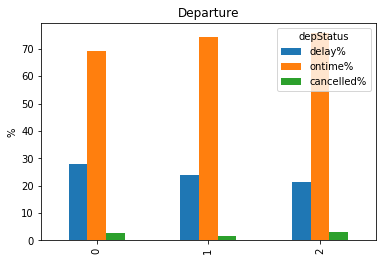

In [26]:
flight_dep[["delay%","ontime%","cancelled%"]].plot(kind ="bar", title = "Departure")
plt.ylabel("%")
plt.show()

In [27]:
flight_temp=flight.groupby(["origin","month","depStatus"])["depStatus"].agg("count").unstack("depStatus")

In [28]:
flight_dep=flight_temp.rename(columns=str).reset_index()
flight_dep.rename(columns=str).reset_index()
flight_dep["total"]=flight_dep["cancelled"]+flight_dep["late"]+flight_dep["onTime"]
flight_dep["delay%"]=flight_dep.late/flight_dep.total*100
flight_dep["ontime%"]=flight_dep.onTime/flight_dep.total*100
flight_dep["cancelled%"]=flight_dep.cancelled/flight_dep.total*100
flight_dep

depStatus,origin,month,cancelled,late,onTime,total,delay%,ontime%,cancelled%
0,EWR,1,238,2750,6905,9893,27.797433,69.796826,2.405741
1,EWR,2,499,2346,6262,9107,25.760404,68.760294,5.479302
2,EWR,3,367,3239,6814,10420,31.084453,65.393474,3.522073
3,EWR,4,260,3109,7162,10531,29.522363,68.008736,2.468901
4,EWR,5,249,3278,7065,10592,30.947885,66.701284,2.350831
5,EWR,6,377,3482,6316,10175,34.221130,62.073710,3.705160
6,EWR,7,279,3578,6618,10475,34.157518,63.178998,2.663484
7,EWR,8,177,2780,7402,10359,26.836567,71.454774,1.708659
8,EWR,9,143,1653,7754,9550,17.308901,81.193717,1.497382
9,EWR,10,92,2093,7919,10104,20.714568,78.374901,0.910530


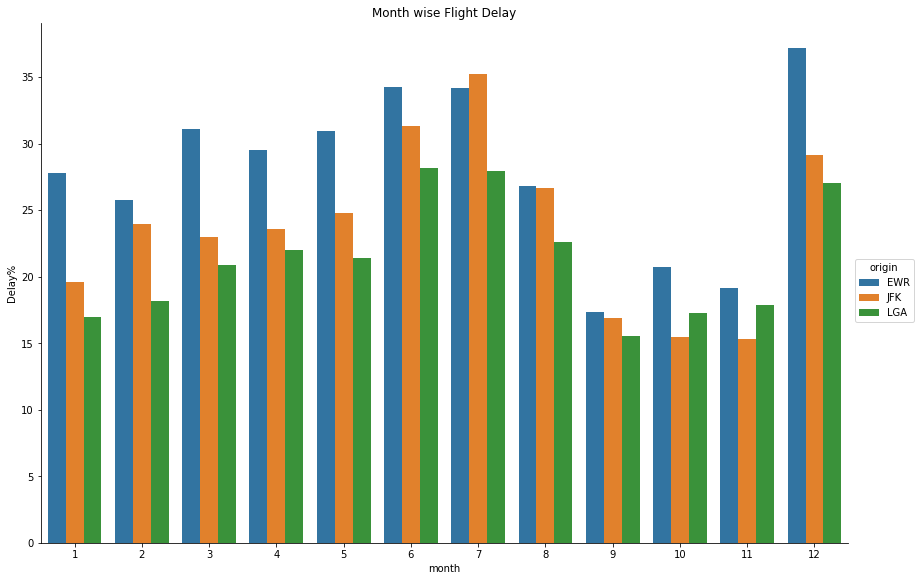

In [29]:
ax = sns.factorplot(x="month", y="delay%", hue="origin", data=flight_dep, 
                    kind="bar",aspect=1.5, size=8)
ax.set(ylabel='Delay%')
plt.title('Month wise Flight Delay');

In [30]:
flight_dep=flight[flight.depStatus=="late"]
flight_dep.drop(['arr_time','sched_arr_time','arr_delay','flight','tailnum','distance','minute','time_hour'],axis=1,inplace=True)
flight_dep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82834 entries, 26 to 336768
Data columns (total 17 columns):
month                 82834 non-null category
day                   82834 non-null int8
dep_time              82834 non-null float64
sched_dep_time        82834 non-null int64
dep_delay             82834 non-null float64
carrier               82834 non-null category
origin                82834 non-null category
dest                  82834 non-null category
air_time              82834 non-null float16
hour                  82834 non-null int8
dep_time_new          82834 non-null timedelta64[ns]
arr_time_new          82834 non-null timedelta64[ns]
sched_dep_time_new    82834 non-null timedelta64[ns]
sched_arr_time_new    82834 non-null timedelta64[ns]
weekday               82834 non-null object
depStatus             82834 non-null category
arrstatus             82834 non-null category
dtypes: category(6), float16(1), float64(2), int64(1), int8(2), object(1), timedelta64[ns](4)
m

C:\Users\lvora\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


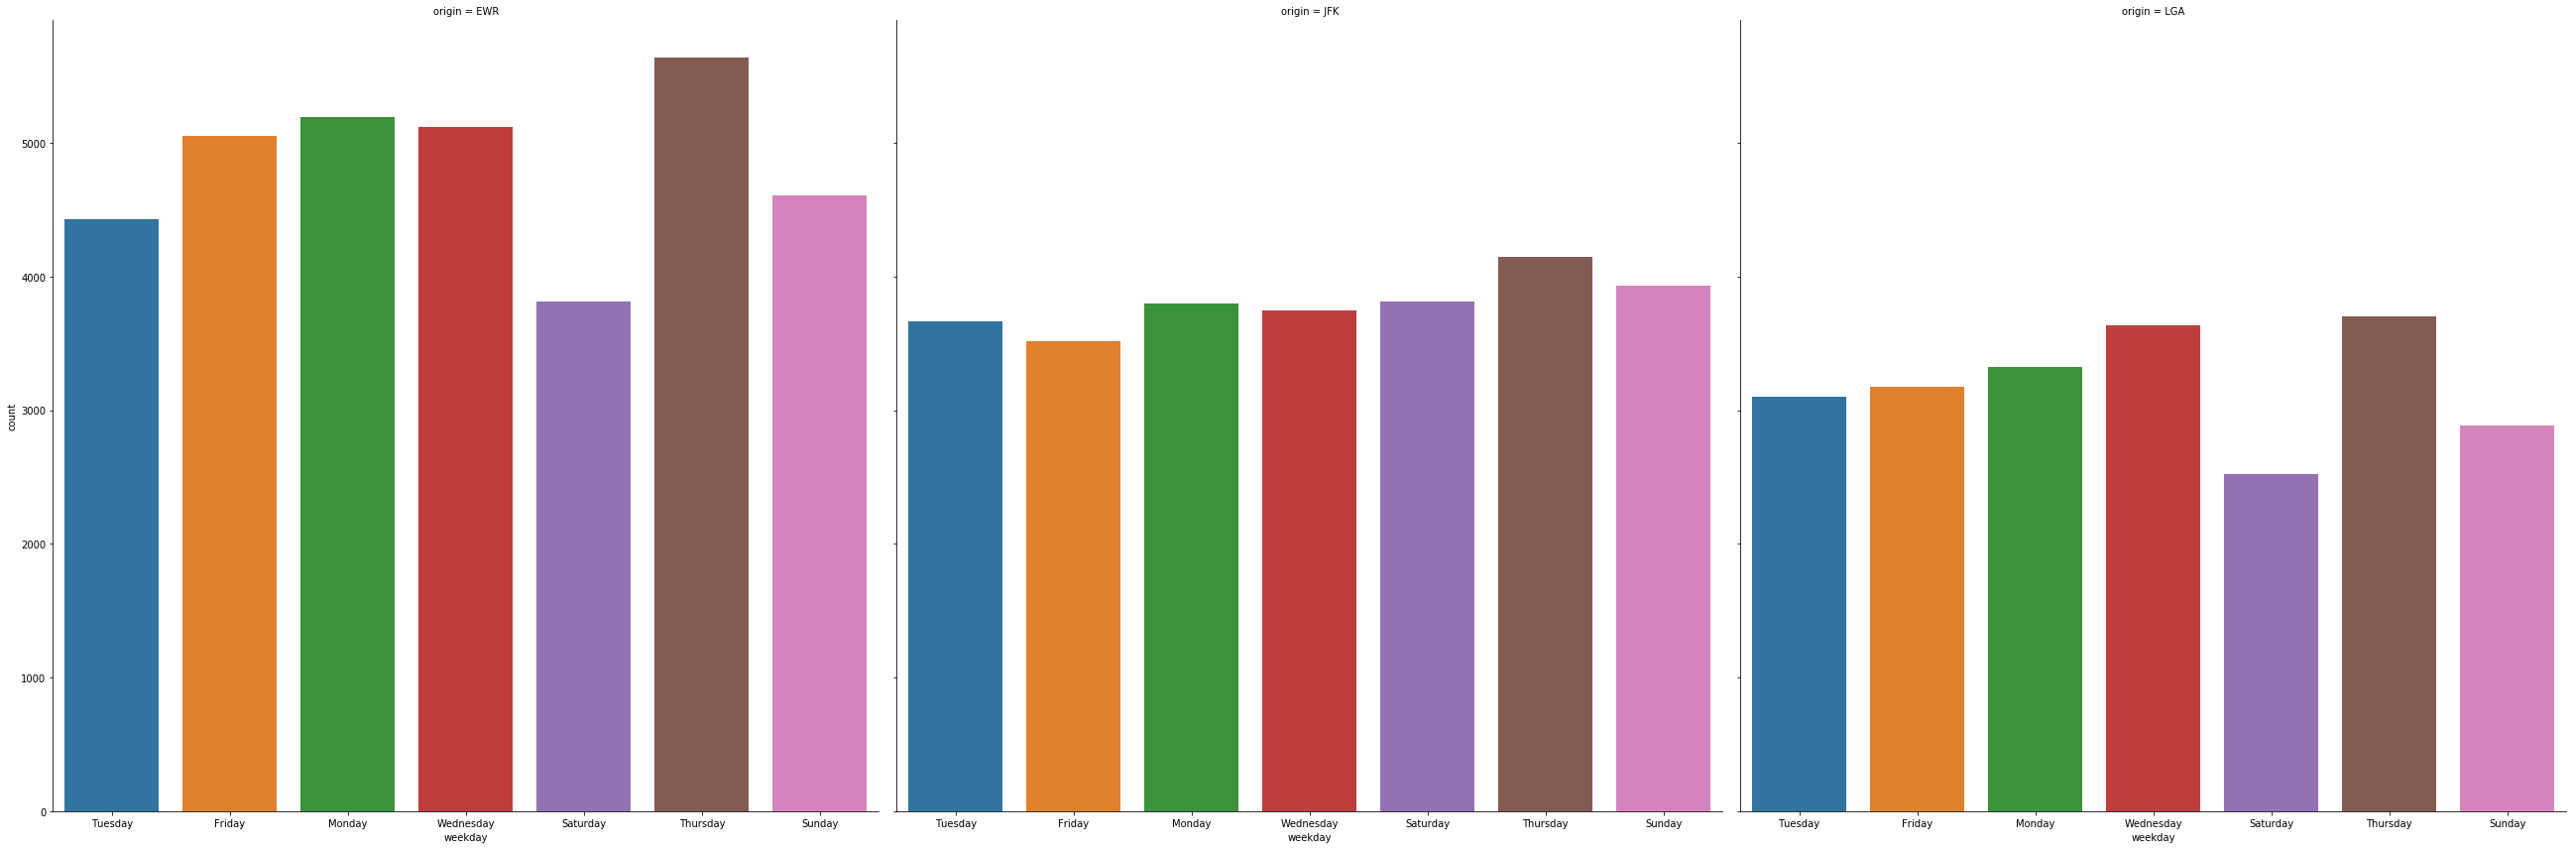

In [31]:
sns.factorplot(x="weekday",
               col="origin", data=flight_dep, kind="count", size=12);

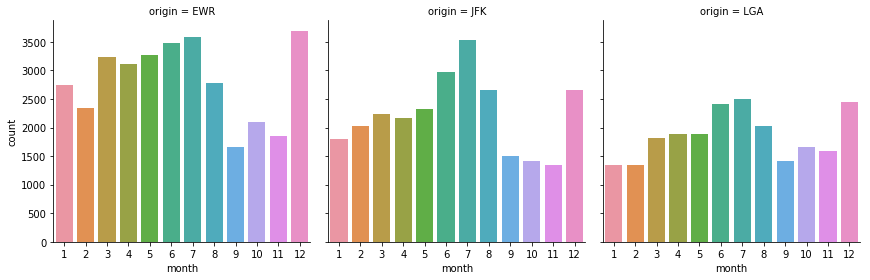

In [32]:
sns.factorplot(x="month",
               col="origin", data=flight_dep, kind="count");

# Airport EWR has most number of delayed flights in all months, except July month. Airport LGA is best in terms of handling flights, and has minimum number of delayed flight, however JFK airport has performed better in October and november month in terms of delayed flights.

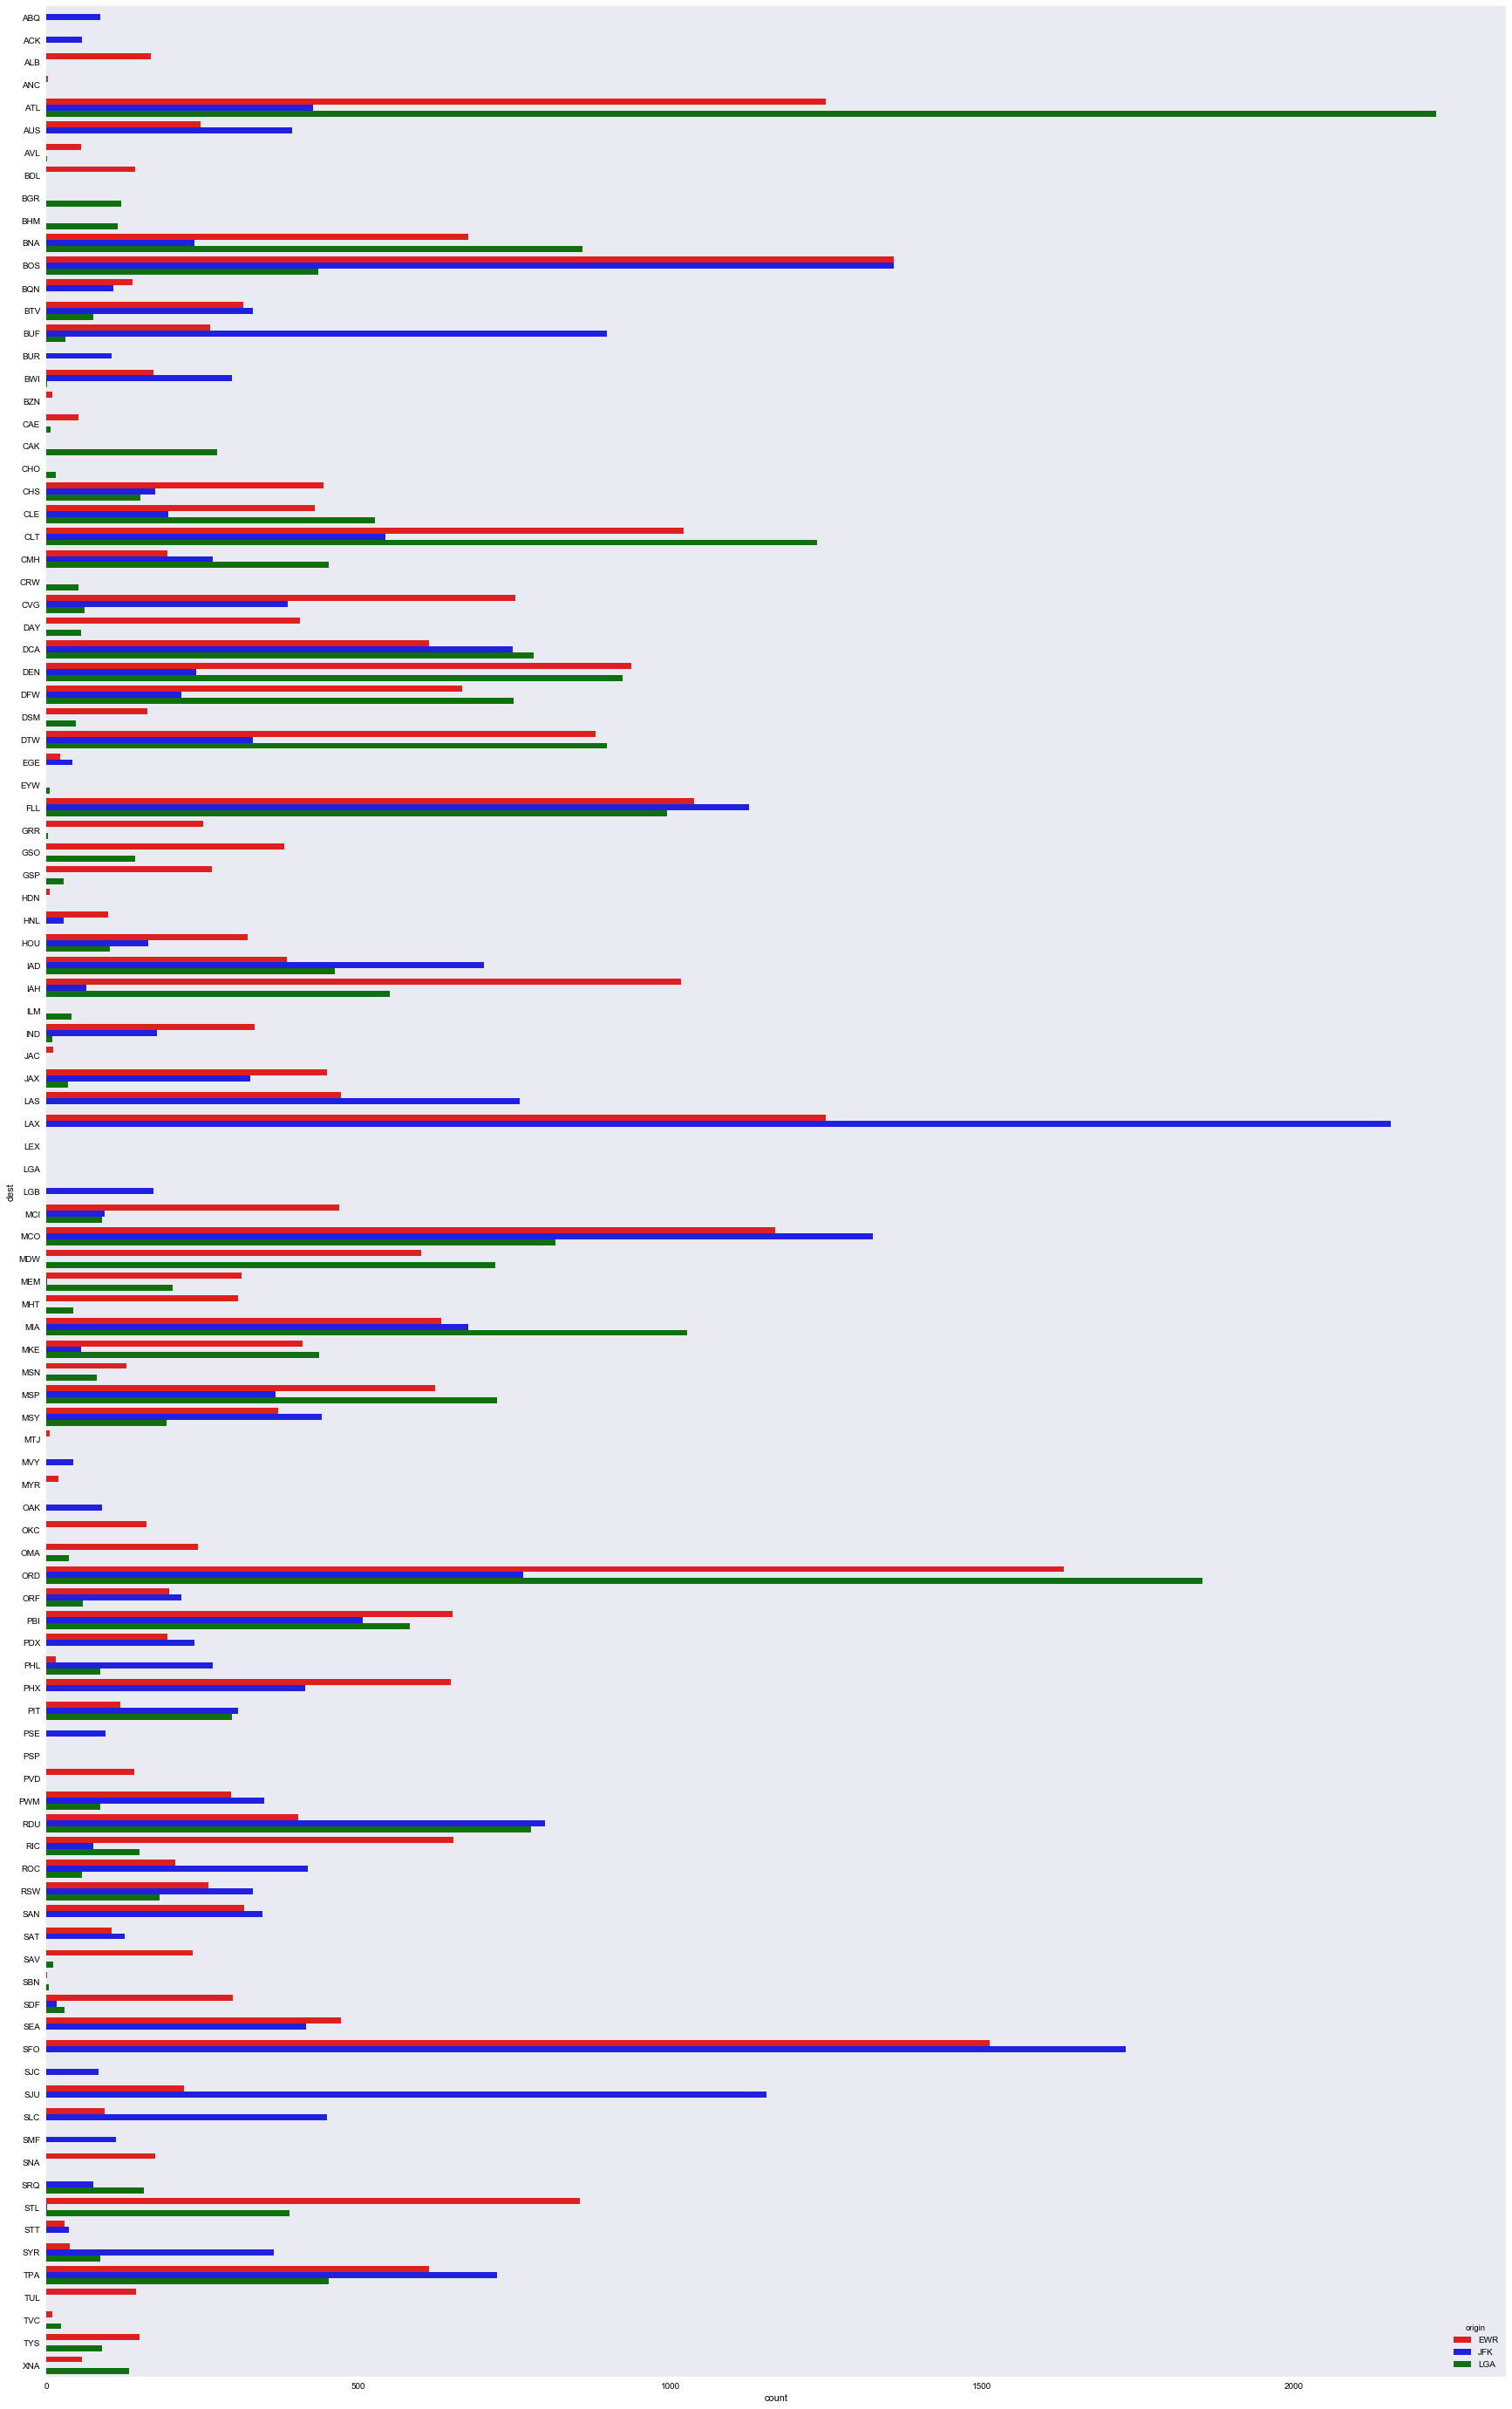

In [33]:
sns.set(rc={"font.style":"normal",
            
            "text.color":"black",
            "xtick.color":"black",
            "ytick.color":"black",
            "axes.labelcolor":"black",
            "axes.grid":False,
            'figure.figsize':(30.0, 50.0),
            })
sns.countplot(y="dest", hue="origin", data=flight_dep, palette=["red", "blue", "green"],saturation=0.75);


## Departure Delays

In [34]:
flight_delays=flight[["origin","dest","month","day","dep_time","sched_dep_time","dep_delay","weekday","depStatus","hour","time_hour"]]

In [35]:
flight_delays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336776 entries, 0 to 336775
Data columns (total 11 columns):
origin            336776 non-null category
dest              336776 non-null category
month             336776 non-null category
day               336776 non-null int8
dep_time          328521 non-null float64
sched_dep_time    336776 non-null int64
dep_delay         328521 non-null float64
weekday           336776 non-null object
depStatus         336776 non-null category
hour              336776 non-null int8
time_hour         336776 non-null datetime64[ns]
dtypes: category(4), datetime64[ns](1), float64(2), int64(1), int8(2), object(1)
memory usage: 14.8+ MB


In [36]:
mask=flight_delays.depStatus=="late"

In [37]:
flight_delays=flight_delays.loc[mask][["origin","time_hour","month","weekday","hour","dep_delay"]]

In [38]:
flight_delays.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82834 entries, 26 to 336768
Data columns (total 6 columns):
origin       82834 non-null category
time_hour    82834 non-null datetime64[ns]
month        82834 non-null category
weekday      82834 non-null object
hour         82834 non-null int8
dep_delay    82834 non-null float64
dtypes: category(2), datetime64[ns](1), float64(1), int8(1), object(1)
memory usage: 2.8+ MB


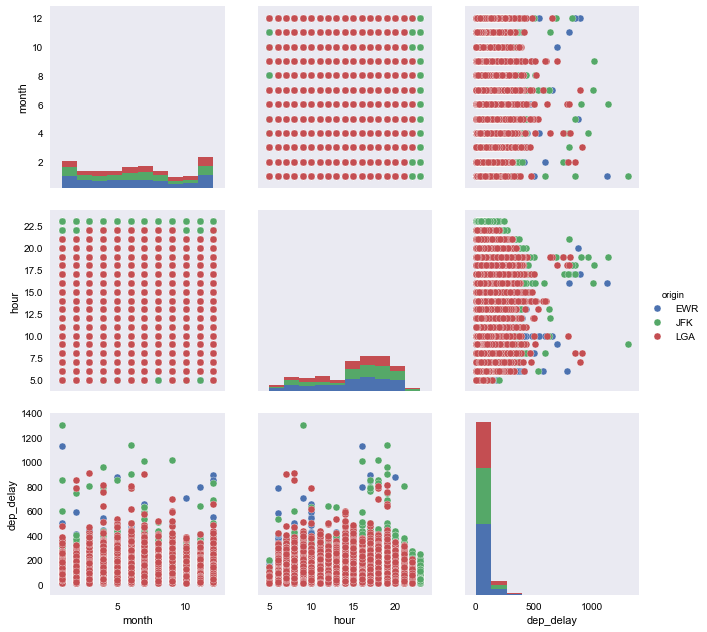

In [39]:
sns.pairplot(flight_delays, hue='origin', size=3, aspect=1);

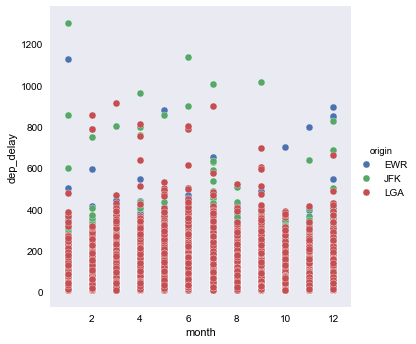

In [40]:
g = sns.pairplot(flight_delays, x_vars=["month"],y_vars=["dep_delay"], hue="origin", size=5)

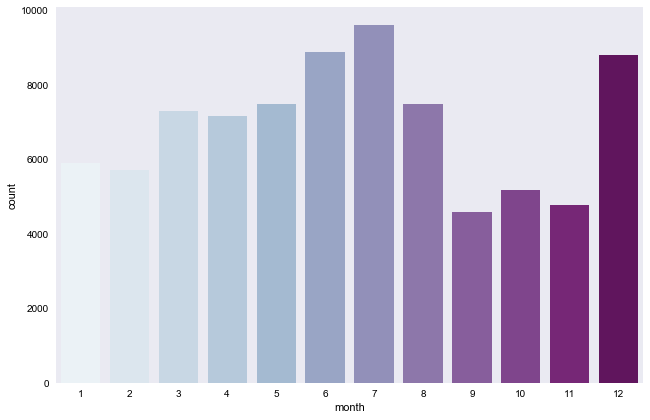

In [41]:
g = sns.factorplot(x="month", data=flight_delays, kind="count",
                   palette="BuPu", size=6, aspect=1.5)

# This shows us that there is a PEAK in delays during June, July & August month and the delays generally fall down during  October, November and again slightly increasing in December.


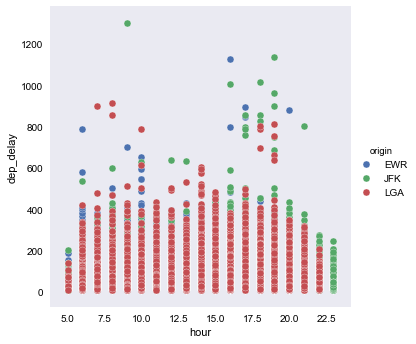

In [42]:
g = sns.pairplot(flight_delays, x_vars=["hour"],y_vars=["dep_delay"], hue="origin", size=5)

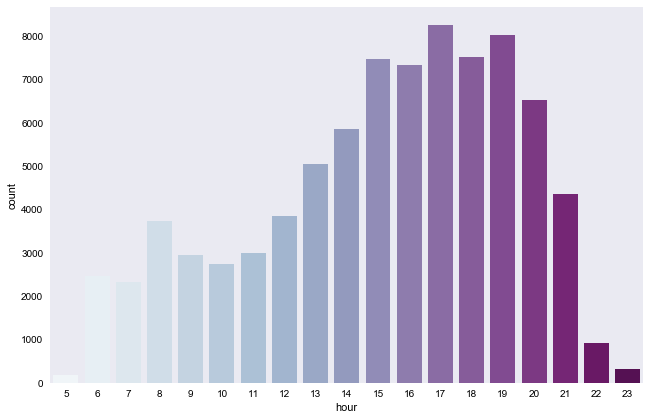

In [43]:
g = sns.factorplot(x="hour", data=flight_delays, kind="count",
                   palette="BuPu", size=6, aspect=1.5)

# This shows that there is significant delay for flights which depart  in evening from 15:00 hrs to 20:00 hrs.


# Aircraft speed analysis

In [44]:
flight['date'] = "2013" + "-" + flight['month'].astype(str) + "-" + flight['day'].astype(str)

In [45]:
flight['speed_in_mph'] = flight.distance/(flight.air_time/60)

x = ['date','carrier','tailnum','flight','origin','dest','air_time','distance','speed_in_mph']

#flight.sort_values('speed_in_mph',ascending = False)[x].head(1)
flight.sort_values('speed_in_mph',ascending = False)[x].head(10)

,date,carrier,tailnum,flight,origin,dest,air_time,distance,speed_in_mph
216447,2013-5-25,DL,N666DN,1499,LGA,ATL,65.0,762,703.596032
251999,2013-7-2,EV,N17196,4667,EWR,MSP,93.0,1008,650.404537
205388,2013-5-13,EV,N14568,4292,EWR,GSP,55.0,594,648.115077
157516,2013-3-23,EV,N12567,3805,EWR,BNA,70.0,748,640.964017
10223,2013-1-12,DL,N956DL,1902,LGA,PBI,105.0,1035,591.428571
70640,2013-11-17,DL,N3768,315,JFK,SJU,170.0,1598,563.870434
129835,2013-2-21,B6,N779JB,707,JFK,SJU,172.0,1598,557.340599
70704,2013-11-17,AA,N5FFAA,936,JFK,STT,175.0,1623,556.581380
87723,2013-12-5,AA,N617AA,1029,JFK,SJU,173.0,1598,554.319783
70551,2013-11-16,DL,N3773D,347,JFK,SJU,173.0,1598,554.319783


# Flight 1499 with Tail number N666DN traveling between LGA to ATL Airport was the fastest in terms of speed in miles per hour. 


# Maximum number of flights headed to some particular destination

In [48]:
flight.groupby("dest")["dest"].count().sort_values(ascending = False).head(1)

dest
ORD    17283
Name: dest, dtype: int64

# Maximum number of flights headed in 2013 is to Airport ORD.